# Amazon prime day
## Can we detect an impact?

Amazon prime day started in 2015. Here are the dates: https://www.aboutamazon.com/news/retail/the-history-of-prime-day


In [138]:
from datetime import datetime

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

census_data_dir = '../data/census/'

## US Census retail sales data

The following analysis uses US census data, not Amazon data.


Retail Sales: Pharmacies and Drug Stores
https://fred.stlouisfed.org/series/MRTSSM44611USN 

In [139]:
# sales are in millions of dollars
pharmacies_retail_sales = pd.read_csv(census_data_dir+'pharmacies-retail-sales.csv', parse_dates=['Date']).set_index('Date')
pharmacies_retail_sales.head(3)

,Sales
Date,
2000-01-01,10071
2000-02-01,10132
2000-03-01,10818


In [140]:
yyyy_mm_idx = [d.strftime('%Y-%m') for d in pharmacies_retail_sales.index]
pharmacies_retail_sales.reindex(yyyy_mm_idx).head(3)

,Sales
Date,
2000-01,10071
2000-02,10132
2000-03,10818


In [141]:
amzn_prime_ms = [
    '2015-07',
    '2016-07',
    '2017-07',
    '2018-07',
    '2019-07',
    '2020-10',
    '2021-06',
    '2022-07',
    '2023-07',
]
isPrimeMonth = pd.Series(
    [(1 if ym in amzn_prime_ms else 0) for ym in yyyy_mm_idx], 
    index=pharmacies_retail_sales.index
).rename('isPrimeMonth')
assert(isPrimeMonth.sum() == len(amzn_prime_ms))
isPrimeMonth.head()

Date
2000-01-01    0
2000-02-01    0
2000-03-01    0
2000-04-01    0
2000-05-01    0
Name: isPrimeMonth, dtype: int64

In [142]:
amzn_color = 'blue' 
census_color = 'black'

def plot_monthly_data(series, ax=None, label=None, 
                      show_covid=False, show_prime_dates=False,
                      color=None, linestyle=None, legend=True):
    if ax is None:
        _fig, ax = plt.subplots(1,1, figsize=(14,2))
    ax.plot(series, label=label, color=color, linestyle=(linestyle or '-'))
    ax.set_xlim(series.index[0], series.index[-1])
    if show_covid: ax.axvline(x='2020-03', ymin=0, color='gray', linestyle=':')
    if show_prime_dates: [ax.axvline(x=m, ymin=0, color=amzn_color, alpha=0.5, linestyle=':') for m in amzn_prime_ms]
    if label and legend: ax.legend()
    _ = plt.xticks(rotation=90)
    return ax

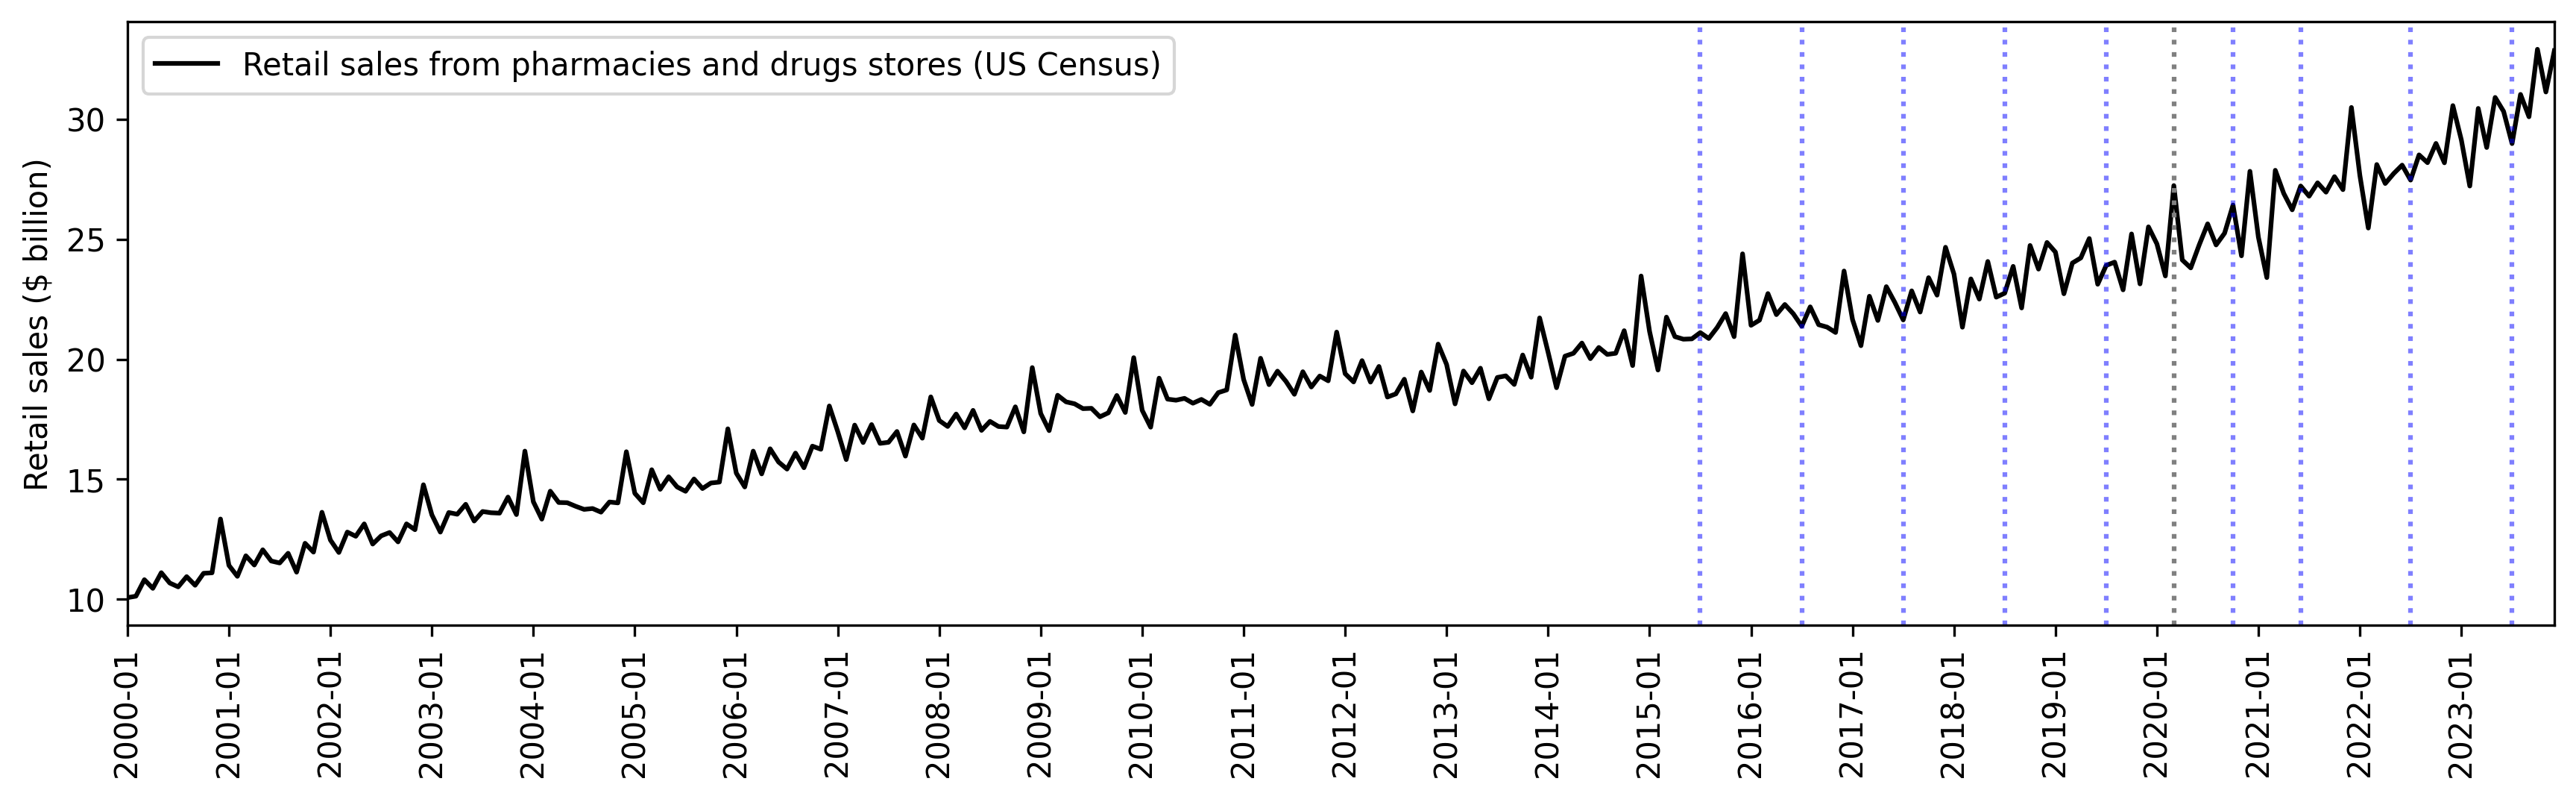

In [143]:
fig, ax = plt.subplots(1,1,figsize=(14,3.5), dpi=300)
ax.set_ylabel('Retail sales ($ billion)')
ax = plot_monthly_data(
    pharmacies_retail_sales.reindex(yyyy_mm_idx)/1000, ax=ax,
    label='Retail sales from pharmacies and drugs stores (US Census)', 
    show_covid=True, show_prime_dates=True,
    color=census_color, legend=True
)
_ = ax.set_xticks([ym for ym in yyyy_mm_idx if ym.endswith('01')])

## SARIMAX Model

In [135]:
pharmacies_retail_sales.index.freq = 'MS' # month start
model = sm.tsa.statespace.SARIMAX(
    pharmacies_retail_sales, trend='c',
#     order=(1,1,1), seasonal_order=(2, 1, 1, 12), # AIC 4235
    order=(1,1,1), seasonal_order=(1, 1, 0, 12), # AIC 4305
    exog=isPrimeMonth,
)
res = model.fit(disp=False)
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                  288
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -2146.941
Date:                             Wed, 11 Sep 2024   AIC                           4305.882
Time:                                     16:57:58   BIC                           4327.583
Sample:                                 01-01-2000   HQIC                          4314.591
                                      - 12-01-2023                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        2.8503     10.930      0.261      0.794     -18.571      24.272
isPrimeMonth    42.6594    167.006      0.255      0.798    -284.667     369.985
ar.L1            0.0041      0.051      0.080      0.936      -0.096       0.104
ma.L1           -0.7013      0.052    -13.387      0.000      -0.804      -0.599
ar.S.L12        -0.1847      0.056     -3.303      0.001      -0.294      -0.075
sigma2        3.318e+05   1.99e+04     16.668      0.000    2.93e+05    3.71e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                78.83
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               4.99   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""